In [7]:
import os
import sys
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tifffile import imread
import skimage
from skimage.segmentation import join_segmentations
from skimage.color import rgb2gray

<tifffile.TiffFrame 388 @157874034> is missing required tags
<tifffile.TiffFile 'cellsonlyA1.ome.tiff'> OME series expected 388 frames, got 389


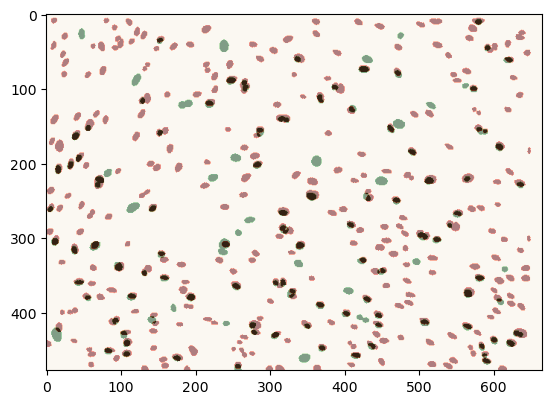

In [16]:
cell_id = 'cellsonlyA1'

fpath = f"/scratch/indikar_root/indikar1/shared_data/apollo/images/{cell_id}.ome.tiff"
raw_img = imread(fpath)

fpath = f"/scratch/indikar_root/indikar1/shared_data/apollo/segmentation/{cell_id}.tiff"
img = imread(fpath)

plt.imshow((img[2, 0, :, :] != 0 ), cmap='Reds', alpha=1.0)
plt.imshow((img[3, 0, :, :] != 0), cmap='Greens', alpha=0.5)

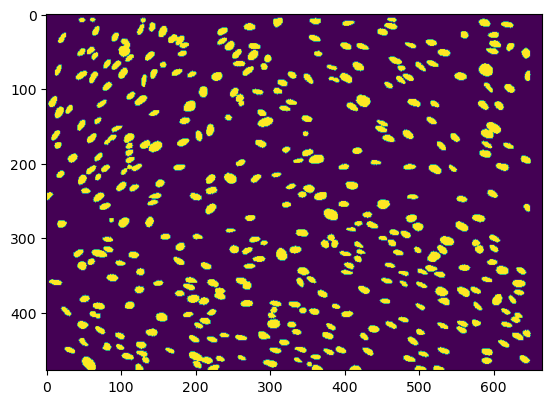

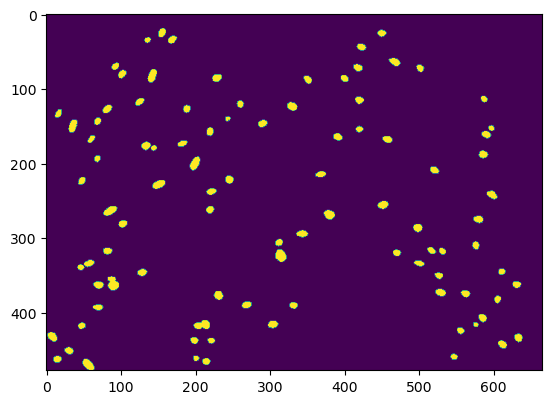

ArrayMap:
  0 → 0
  1 → 0
  ...
  552 → 384
  553 → 385
ArrayMap:
  0 → 0
  1 → 1
  ...
  552 → 0
  553 → 0


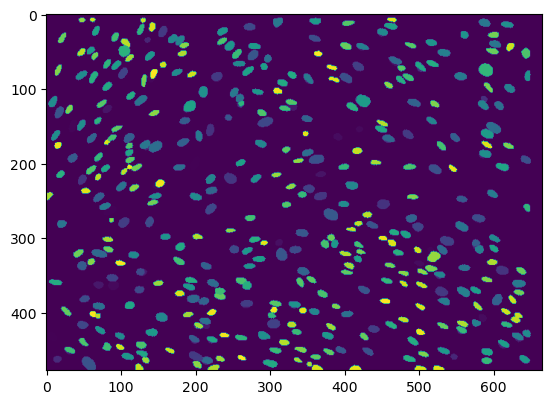

In [13]:
t = 50
# red
seg_1 = img[2, t, :, :]
plt.imshow(seg_1.astype(bool))
plt.show()

# green
seg_2 = img[3, t, :, :]
plt.imshow(seg_2.astype(bool))
plt.show()

joined, mappings_1, mappings_2 = join_segmentations(seg_1.astype(int), seg_2.astype(int), return_mapping = True)
plt.imshow(joined)
print(mappings_1)
print(mappings_2)

## Cell Counting

In [17]:
def count_cells_channel(channel):
    unique_cells = np.unique(channel)
    # Exclude background
    unique_cells = unique_cells[unique_cells != 0]
    return len(unique_cells)

def count_overlap_cells(mappings_1, mappings_2):
    # Sets to track unique overlapping cell IDs
    unique_red_cells = set()
    unique_green_cells = set()
    
    # Loop through unique cells in mappings_1
    for red_cell_id in np.unique(mappings_1):
        if red_cell_id != 0:  # Exclude background
            green_mapped_cells = mappings_2[mappings_1 == red_cell_id]
            # Find the unique green cells that overlap with this red cell
            overlapping_green_cells = np.unique(green_mapped_cells[green_mapped_cells != 0])
            
            if len(overlapping_green_cells) > 0:
                unique_red_cells.add(red_cell_id)
                unique_green_cells.update(overlapping_green_cells)
    
    # Calculate the unique overlap counts for red and green cells
    unique_overlap_count_red = len(unique_red_cells)
    unique_overlap_count_green = len(unique_green_cells)
    
    # If there's a mismatch in the overlap count between red and green, warning
    # if unique_overlap_count_red != unique_overlap_count_green:
        # print(f"Warning: Mismatch in overlap counts! Red: {unique_overlap_count_red}, Green: {unique_overlap_count_green}")
    
    # Return the number of unique overlapping cells (they should be the same)
    return min(unique_overlap_count_red, unique_overlap_count_green)

def count_cells_img(img):
    num_channels, time, height, width = img.shape
    
    time_points = []
    red_counts = []
    green_counts = []
    overlap_counts = []
    
    for t in range(time):
        # Extract red and green channels for time
        red_channel = img[2, t, :, :]
        green_channel = img[3, t, :, :]
        
        # Count cells in red and green
        red_count = count_cells_channel(red_channel)
        green_count = count_cells_channel(green_channel)
        
        # Count overlap
        joined_segmentation, mappings_1, mappings_2 = join_segmentations(
            red_channel.astype(int), green_channel.astype(int), return_mapping=True)
        overlap_count = count_overlap_cells(mappings_1, mappings_2)
        
        time_points.append(t)
        red_counts.append(red_count)
        green_counts.append(green_count)
        overlap_counts.append(overlap_count)
    
    # Create pandas df
    df = pd.DataFrame({
        'Time': time_points,
        'Red': red_counts,
        'Green': green_counts,
        'Both': overlap_counts # not right
    })
    
    df["Red Subtract"] = df["Red"] - df["Both"]
    df["Green Subtract"] = df["Green"] - df["Both"]
    
    return df

result = count_cells_img(img)
print(result.head())

   Time  Red  Green  Both  Red Subtract  Green Subtract
0     0  339    129   101           238              28
1     1  341    123    97           244              26
2     2  364    116    93           271              23
3     3  360    109    87           273              22
4     4  359    116    95           264              21


In [22]:
# CELL COUNTING ALT

def count_cells_intersect(raw_img, img):
    result = []

    for t in range(img.shape[1]):
    
        # get each channel
        red_image = img[2, t, :, :]
        green_image = img[3, t, :, :]
    
        # count the number of unique segmentations in both channels
        n_red = len(np.unique(red_image)) - 1
        n_green = len(np.unique(green_image)) - 1
    
        # compute the overlap between segmentations
        # fraction of red_image that overlaps with green_image
        red_overlap = skimage.measure.intersection_coeff(
        red_image.astype(bool), 
        green_image.astype(bool)
        )
    
        # fraction of green_image that overlaps with red_image
        green_overlap = skimage.measure.intersection_coeff(
        green_image.astype(bool), 
        red_image.astype(bool),
        )
    
        # mander's colocalization for both channels
        # proportion of red intensity is in green segmentations
        red_colocalization = skimage.measure.manders_coloc_coeff(
        rgb2gray(raw_img[2, t, :, :]), 
        green_image.astype(bool),
        )
    
        # proportion of green intensity is in red segmentations
        green_colocalization = skimage.measure.manders_coloc_coeff(
        rgb2gray(raw_img[3, t, :, :]), 
        red_image.astype(bool),
        )
    
        row = {
            'Time' : t,
            'Red Raw' : n_red,
            'Green Raw' : n_green,
            'Red Overlap' : red_overlap,
            'Green Overlap' : green_overlap,
            'Red Colocalization' : red_colocalization,
            'Green Colocalization' : green_colocalization,
        }
    
        result.append(row)
    
    result = pd.DataFrame(result)
    # Calculate the 'both' count from red overlap
    both_from_red = result['Red Raw'] * (result['Red Overlap'])

    # Calculate the 'both' count from green overlap
    both_from_green = result['Green Raw'] * (result['Green Overlap'])

    # Ideally, these should be close. Let's take the average for a more robust estimate
    both_avg = (both_from_red + both_from_green) / 2

    # Calculate exclusively red and green counts
    only_red = result['Red Raw'] - both_avg
    only_green = result['Green Raw'] - both_avg

    # Add these calculated columns to your DataFrame
    result['Both'] = both_avg.astype(int)
    result['Red Subtract'] = only_red.astype(int)
    result['Green Subtract'] = only_green.astype(int)

    return result

cell_id = 'cellsonlyA1'

fpath = f"/scratch/indikar_root/indikar1/shared_data/apollo/images/{cell_id}.ome.tiff"
raw_img = imread(fpath)

fpath = f"/scratch/indikar_root/indikar1/shared_data/apollo/segmentation/{cell_id}.tiff"
img = imread(fpath)

result_2 = count_cells_intersect(raw_img, img)
print(result.head())
print(result_2.head())

<tifffile.TiffFrame 388 @157874034> is missing required tags
<tifffile.TiffFile 'cellsonlyA1.ome.tiff'> OME series expected 388 frames, got 389


   Time  Red  Green  Both  Red Subtract  Green Subtract
0     0  339    129   101           238              28
1     1  341    123    97           244              26
2     2  364    116    93           271              23
3     3  360    109    87           273              22
4     4  359    116    95           264              21
   Time  Red Raw  Green Raw  Red Overlap  Green Overlap  Red Colocalization  \
0     0      339        129     0.230115       0.545985            0.278987   
1     1      341        123     0.226756       0.567678            0.237117   
2     2      364        116     0.202447       0.565743            0.203223   
3     3      360        109     0.192354       0.583072            0.178988   
4     4      359        116     0.209867       0.621495            0.175308   

   Green Colocalization  Both  Red Subtract  Green Subtract  
0              0.105337    74           264              54  
1              0.108846    73           267              49  
2  

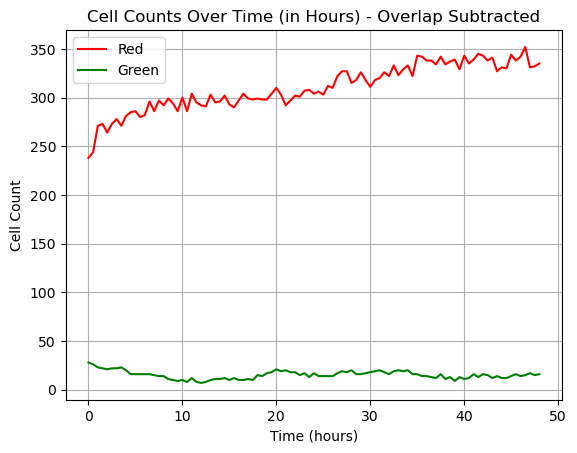

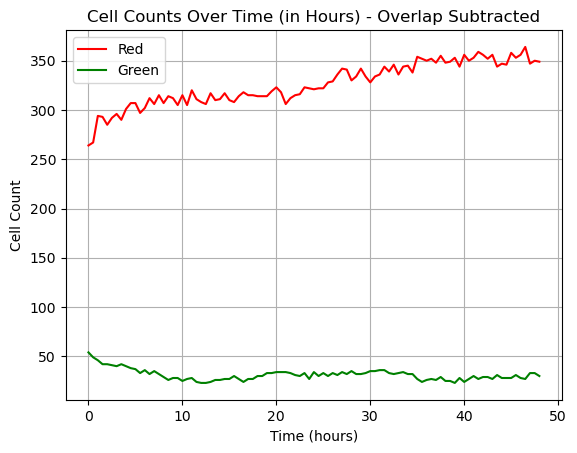

In [23]:
def plot_result_no_overlap(result):
    result['Hour'] = result['Time'] / 2

    plt.figure()

    # Plotting each cell type
    sns.lineplot(x='Hour', y='Red', data=result, label='Red', color = 'red')
    sns.lineplot(x='Hour', y='Green', data=result, label='Green', color = 'green')
    # sns.lineplot(x='Hour', y='Both', data=result, label='Both', color = 'blue')

    plt.title('Cell Counts Over Time (in Hours)')
    plt.xlabel('Time (hours)')
    plt.ylabel('Cell Count')
    plt.grid(True)
    
    plt.legend()
    
    plt.show()
    
def plot_result_overlap(result):
    result['Hour'] = result['Time'] / 2

    plt.figure()

    # Plotting each cell type
    sns.lineplot(x='Hour', y='Red Subtract', data=result, label='Red', color = 'red')
    sns.lineplot(x='Hour', y='Green Subtract', data=result, label='Green', color = 'green')
    # sns.lineplot(x='Hour', y='Both', data=result, label='Both', color = 'blue')

    plt.title('Cell Counts Over Time (in Hours) - Overlap Subtracted')
    plt.xlabel('Time (hours)')
    plt.ylabel('Cell Count')
    plt.grid(True)
    
    plt.legend()
    
    plt.show()


# plot_result_no_overlap(result)
plot_result_overlap(result)
plot_result_overlap(result_2)

In [26]:
dpath = f"/scratch/indikar_root/indikar1/shared_data/apollo/images/mmRNA4OHTsiRNAB4.tiff"
raw_img = imread(dpath)

dpath = f"/scratch/indikar_root/indikar1/shared_data/apollo/segmentation/mmRNA4OHTsiRNAB4.tiff"
img = imread(dpath)
result = count_cells_img(img)
result_2 = count_cells_intersect(raw_img, img)
print(result.head())
print(result_2.head())
plot_result_overlap(result)
plot_result_overlap(result_2)

FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/accounts/indikar_root/indikar1/shared_data/apollo/images/mmRNA4OHTsiRNAB4.tiff'

## Stats

In [28]:
from scipy.stats import chi2_contingency

def test_proportion_constancy(df):
    # Perform a chi-squared test to check if green remains constant across time points
    observed = df[['Green Subtract', 'Red Subtract', 'Both']].values
    chi2, p_value, _, _ = chi2_contingency(observed, correction=False)
    return p_value

def analyze_results(results):
    analysis = []
    
    for file_name, df in results:
        p_value = test_proportion_constancy(df)
        # True = signficant difference, False = no significant difference
        analysis.append({'File': file_name, 'P-Value': p_value, 'Significant': p_value < 0.05})
        
    analysis_df = pd.DataFrame(analysis)
    return analysis_df

In [ ]:
fpath = "/scratch/indikar_root/indikar1/shared_data/apollo/segmentation"

file_list = glob.glob(os.path.join(fpath, "*"))

results = []

for file in file_list:
    img = imread(file)
    df = count_cells_img(img)
    file_name = os.path.splitext(os.path.basename(file))[0]
    results.append((file_name, df))

analysis_results = analyze_results(results)
analysis_results = analysis_results.sort_values('File')
print(analysis_results)

In [ ]:
# File paths for segmented images and raw images
fpath_img = "/scratch/indikar_root/indikar1/shared_data/apollo/segmentation"
fpath_raw = "/scratch/indikar_root/indikar1/shared_data/apollo/images"

# Get list of segmented image files
file_list_seg = glob.glob(os.path.join(fpath_img, "*"))

results = []

for file_seg in file_list_seg:
    # Read in segmented image
    img = imread(file_seg)
    
    # Get the base filename without extension
    file_name = os.path.splitext(os.path.basename(file_seg))[0]
    
    # Construct the corresponding raw image file path based on the segmented file name
    file_raw = os.path.join(fpath_raw, file_name + ".tif")  # Adjust the extension if necessary
    
    # Check if the raw image file exists
    if os.path.exists(file_raw):
        raw_img = imread(file_raw)
        
        # Process segmented image (count cells or other analyses)
        df = count_cells_intersect(raw_img, img)
        
        # Append the results with both segmented and raw image info
        results.append((file_name, df))  # Store raw image alongside data
    else:
        print(f"Raw image for {file_name} not found.")

# Analyze the results
analysis_results = analyze_results(results)

# Sort results by file name
analysis_results = analysis_results.sort_values('File')

# Print the sorted results
print(analysis_results)


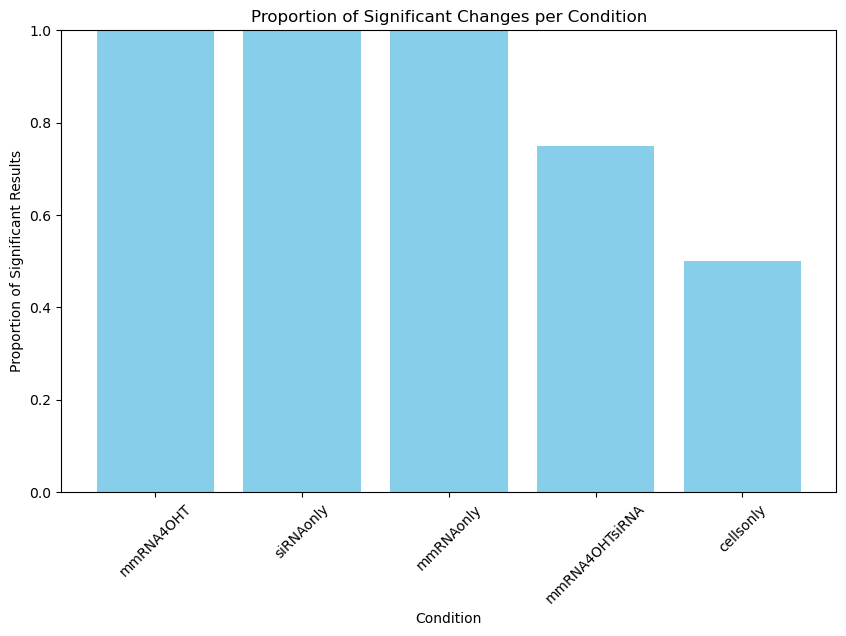

In [43]:
def analyze_by_condition(df):
    conditions = ['mmRNA4OHTsiRNA', 'mmRNA4OHT', 'mmRNAonly', 'siRNAonly', 'cellsonly']

    # Create a new column 'Condition' based on the prefix matching one of the conditions
    df['Condition'] = df['File'].apply(lambda x: next((cond for cond in conditions if x.startswith(cond)), 'Unknown'))

    # Calculate proportion of significant results per condition
    condition_analysis = df.groupby('Condition')['Significant'].mean().reset_index()
    condition_analysis.columns = ['Condition', 'Proportion_Significant']

    # Sort by proportion of significant results
    condition_analysis = condition_analysis.sort_values(by='Proportion_Significant', ascending=False)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.bar(condition_analysis['Condition'], condition_analysis['Proportion_Significant'], color='skyblue')
    plt.xlabel('Condition')
    plt.ylabel('Proportion of Significant Results')
    plt.title('Proportion of Significant Changes per Condition')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.show()

analyze_by_condition(analysis_results)

In [ ]:
from scipy.stats import chi2
# Cochran Armitage test -- looks for trends across time points

def test_cochran_armitage(df):
    successes = df['Red'].values
    n = df['Green'].values + df['Red'].values
    scores = np.arange(len(successes))
    
    total_n = n.sum()
    p_hat = successes.sum() / total_n
    expected = n * p_hat
    
    weights = scores - np.mean(scores)
    numerator = (weights * (successes - expected)).sum() ** 2
    denominator = (weights**2 * expected * (1 - p_hat)).sum()
    
    z_statistic = numerator / denominator
    p_value = chi2.sf(z_statistic, df=1)  # df=1 for a trend test
    
    return p_value

def analyze_ca_results(results):
    analysis = []
    
    for file_name, df in results:
        p_value = test_cochran_armitage(df)
        analysis.append({'File': file_name, 'P-Value': p_value, 'Significant': p_value < 0.05})
        
    analysis_df = pd.DataFrame(analysis)
    return analysis_df

analysis_results = analyze_ca_results(results)
analysis_results = analysis_results.sort_values('File')
print(analysis_results)

## ^ Notes
Comparing the observed counts of green and red cells at each time point with the expected counts (assume proportions constant), test calculates a statistic to assess if any differences are statistically significant. If the p-value from the test is below 0.05, it suggests that the proportions of green and red cells vary significantly over time, otherwise, suggests that proportions remain stable.

## In progress...

Question: How to use segmented image to consider overlap? Currently have rudimentary spatial comp. using scipy, but can I leverage existing segmentation?

https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.join_segmentations
^ function to consider

To-do
- Count cells by proportion, do chi-squared on proportion across all three conds
- Figure out a way to plot it
- For each image, is there a sig. difference in proportion at any timepoint
    - Treat proportion as time series signal, ask if peaks and valleys (let there be a prop mean, how does it vary?)
    - Assume that independence not valid across time points in series
- Slides!
- Extra fun!
    - At which timepoints are significant differences occurring, and is there bio relevance

NameError: name 'calculate_overlap' is not defined